In [146]:
import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import trange

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

import superfreq as sf

In [ ]:
mw = gp.MilkyWayPotential()

pot = gp.CCompositePotential()
pot['disk'] = mw['disk']
pot['halo'] = mw['halo']
pot['bar'] = gp.LongMuraliBarPotential(5e9, a=2., b=0.75, c=0.25, 
                                       units=galactic)

pot.circular_velocity([8.1, 0, 0]*u.kpc)[0]

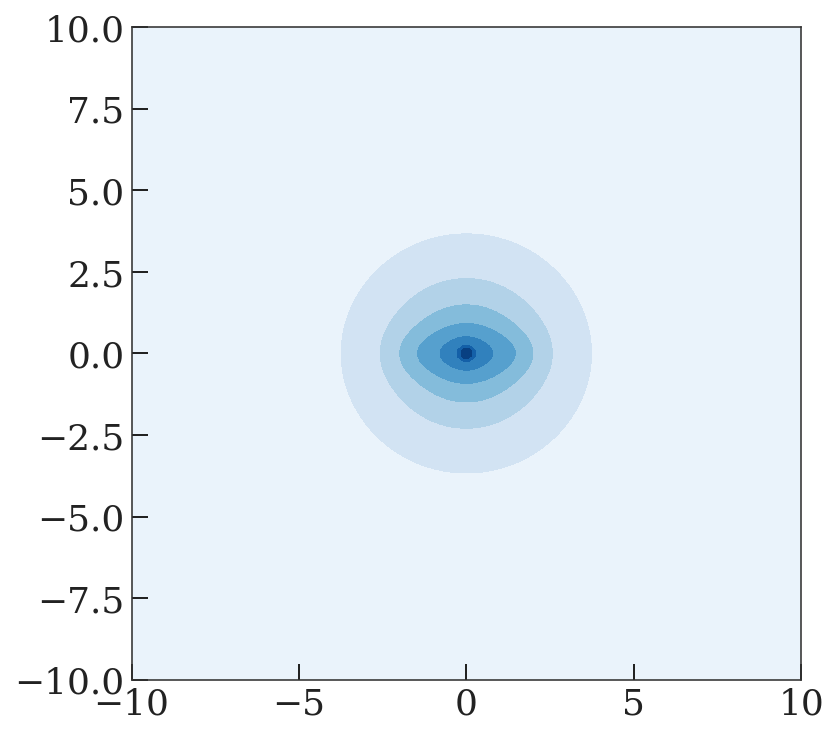

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
_ = pot.plot_density_contours(
    grid=(np.linspace(-10, 10, 128), 
          np.linspace(-10, 10, 128), 
          0.), 
    ax=ax)

In [6]:
Om_p = 40*u.km/u.s/u.kpc
frame = gp.ConstantRotatingFrame(
    [0, 0, -1] * Om_p.to(u.rad/u.Myr, u.dimensionless_angles()), 
    units=galactic)
static_frame = gp.StaticFrame(galactic)

H = gp.Hamiltonian(pot, frame)

# Location of the Lindblad resonances

$\Omega(R) = \frac{v_c(r)}{R}$

$\kappa(R)^2 = \frac{d^2\Phi}{dR^2} + 3\frac{v_c(R)^2}{R^2}$

In [8]:
R = np.linspace(0, 20, 128) * u.kpc
xyz = np.array([[1, 0, 0]]).T * R[None]
vc = pot.circular_velocity(xyz)
Omega = vc / R

13.070866141732283
9.606299212598426
8.346456692913385
7.716535433070866
7.4015748031496065
7.086614173228346


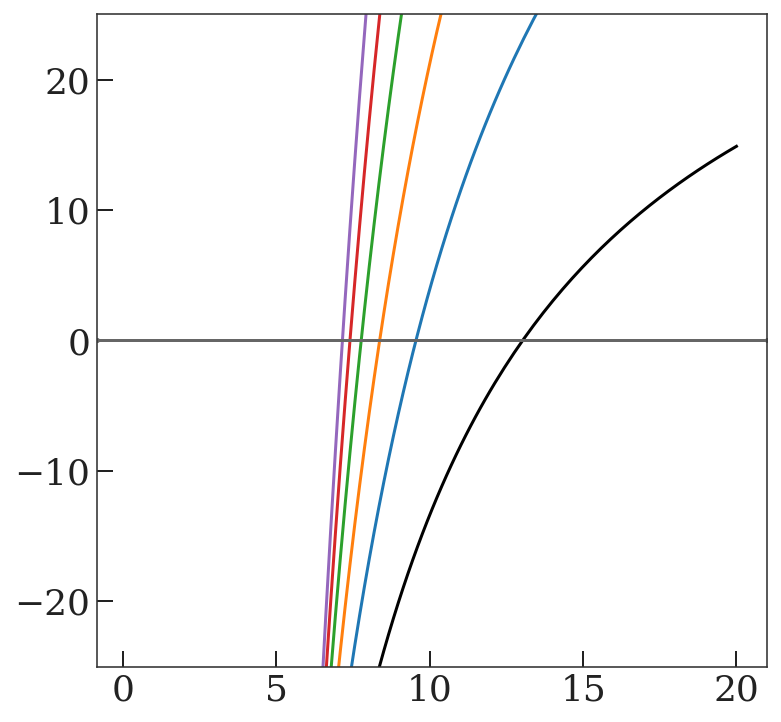

In [9]:
for m in range(1, 6+1):
    lhs = -m * (Omega - Om_p)
    rhs = np.sqrt(pot.hessian(xyz)[0, 0] + 3*Omega**2).to(lhs.unit)
    plt.plot(R.value, lhs - rhs, marker='')
    print(R.value[np.nanargmin(np.abs(lhs - rhs))])

plt.ylim(-25, 25)
plt.axhline(0)

# Visualize results from script

In [151]:
tbl = at.QTable.read('../scripts/bar-orbit-freqs.fits')

In [163]:
max_freq_diff = np.abs((tbl['freq1'] - tbl['freq2']) / tbl['freq1']).max(axis=1)
max_freq_diff.shape

(262144,)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  if __name__ == '__main__':


Text(0, 0.5, '$v_R$ [km/s]')

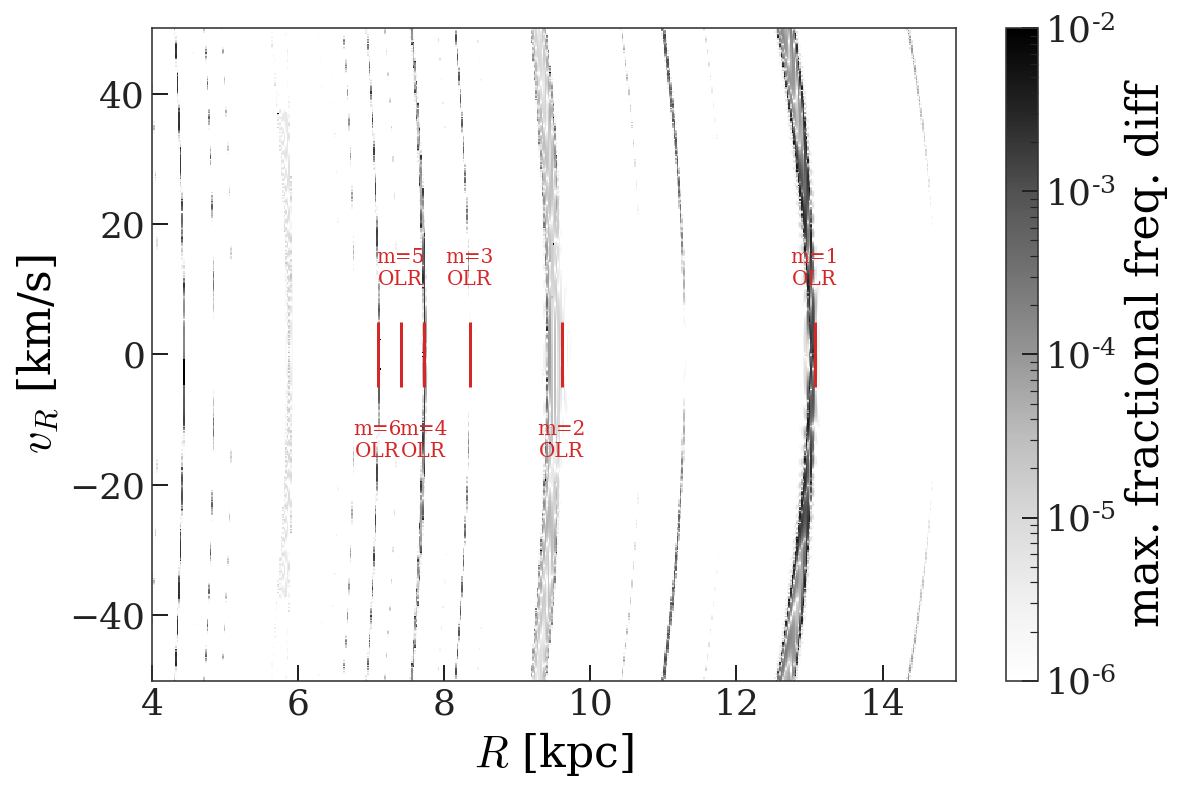

In [172]:
grid_shape = (512, 512)

plt.figure(figsize=(9, 6))
plt.pcolormesh(tbl['R'].value.reshape(grid_shape), 
               tbl['vR'].value.reshape(grid_shape),
               max_freq_diff.value.reshape(grid_shape),
               norm=mpl.colors.LogNorm(),
               vmin=1e-6, vmax=1e-2, 
               cmap='Greys')
cb = plt.colorbar()
cb.set_label('max. fractional freq. diff')

olrs = [13.070866141732283,
9.606299212598426,
8.346456692913385,
7.716535433070866,
7.4015748031496065,
7.08661417]
plt.vlines(olrs, ymin=-5, ymax=5, color='tab:red')

ud = 1.
for m, val in zip(np.arange(1, len(olrs)+1), olrs):
    if ud > 0:
        va = 'bottom'
    else:
        va = 'top'
    plt.text(val, ud * 10, f'm={m}\nOLR', 
             ha='center', color='tab:red', va=va)
    ud *= -1

plt.xlabel('$R$ [kpc]')
plt.ylabel('$v_R$ [km/s]')

In [152]:
tbl['R'].reshape(512, 512).value

<Quantity [[ 4.        ,  4.02152642,  4.04305284, ..., 14.95694716,
            14.97847358, 15.        ],
           [ 4.        ,  4.02152642,  4.04305284, ..., 14.95694716,
            14.97847358, 15.        ],
           [ 4.        ,  4.02152642,  4.04305284, ..., 14.95694716,
            14.97847358, 15.        ],
           ...,
           [ 4.        ,  4.02152642,  4.04305284, ..., 14.95694716,
            14.97847358, 15.        ],
           [ 4.        ,  4.02152642,  4.04305284, ..., 14.95694716,
            14.97847358, 15.        ],
           [ 4.        ,  4.02152642,  4.04305284, ..., 14.95694716,
            14.97847358, 15.        ]] kpc>

In [ ]:
# Surface of section:
style = dict(alpha=0.5, marker='o', mew=0, ms=2, linestyle='none')
fig, axes = plt.subplots(2, 2, figsize=(10, 10),
                         sharex='row', sharey=True,
                         constrained_layout=True)

sos = gd.surface_of_section(orbit, 1)
axes[0, 0].plot(sos.x.value, sos.v_x.to_value(u.km/u.s), **style)
axes[1, 0].plot(sos.cylindrical.rho.value, 
                sos.cylindrical.v_rho.to_value(u.km/u.s), **style)

sos = gd.surface_of_section(orbit_rot, 1)
axes[0, 1].plot(sos.x.value, sos.v_x.to_value(u.km/u.s), **style)
axes[1, 1].plot(sos.cylindrical.rho.value, 
                sos.cylindrical.v_rho.to_value(u.km/u.s), **style)

axes[0, 0].set_ylabel('$v_x$')
for ax in axes[0]:
    ax.set_xlabel('$x$')

axes[1, 0].set_ylabel('$v_R$')

for ax in axes[1]:
    ax.set_xlabel('$R$')

axes[0, 0].set_title('inertial')
axes[0, 1].set_title('rotating')

fig.savefig(plot_path / f'sos-{i+n:05d}.png', dpi=150)
plt.close(fig)

# X-Y
style = dict(alpha=0.2, marker='o', mew=0, ms=1., linestyle='none')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
_ = orbit.plot(['x', 'y'], **style, axes=[axes[0]])
_ = orbit_rot.plot(['x', 'y'], **style, axes=[axes[1]])

lim = orbit.x.max().to_value(u.kpc) + 1

for ax in axes:
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

axes[0].set_title('inertial')
axes[1].set_title('rotating')

fig.savefig(plot_path / f'xy-{i+n:05d}.png', dpi=150)
plt.close(fig)

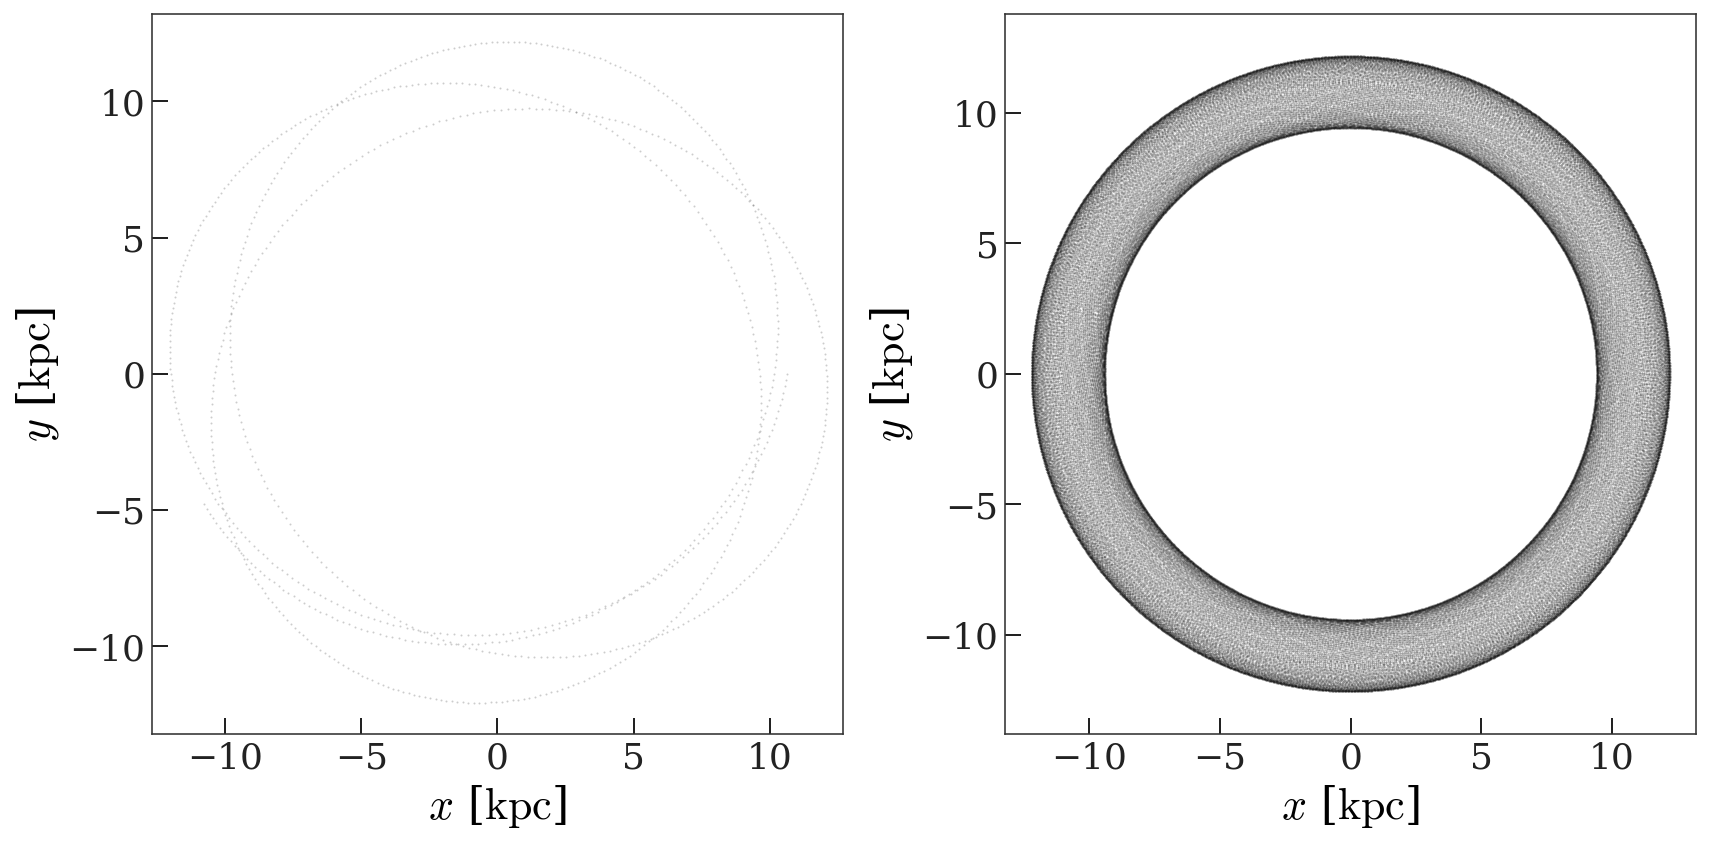

In [122]:
style = dict(alpha=0.2, marker='o', mew=0, ms=1., linestyle='none')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
_ = orbit.plot(['x', 'y'], **style, axes=[axes[0]])
_ = orbit_rot.plot(['x', 'y'], **style, axes=[axes[1]])

lim = orbit.x.max().to_value(u.kpc) + 1

for ax in axes:
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

In [156]:
max_freq_diff = np.max(freq_diffs, axis=1)